In [126]:
import warnings
warnings.filterwarnings("ignore")

import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchinfo import summary

import matplotlib.pyplot as plt
import utils
from utils.dataset import myCocoDetection, coco_show
from utils.metric import get_bbox, mean_average_precision

from tqdm import tqdm

%matplotlib inline

In [113]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_path = r'C:\Users\gjust\Documents\Github\data\COCO\val2017'
test_ann = r'C:\Users\gjust\Documents\Github\data\COCO\annotations\instances_val2017.json'
testset = myCocoDetection(root=test_path, annFile=test_ann, transform=transforms.ToTensor())
test_loader = DataLoader(testset, batch_size=2, shuffle=False, collate_fn=collate_fn)

print(len(testset))

loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
4951


# Visualization

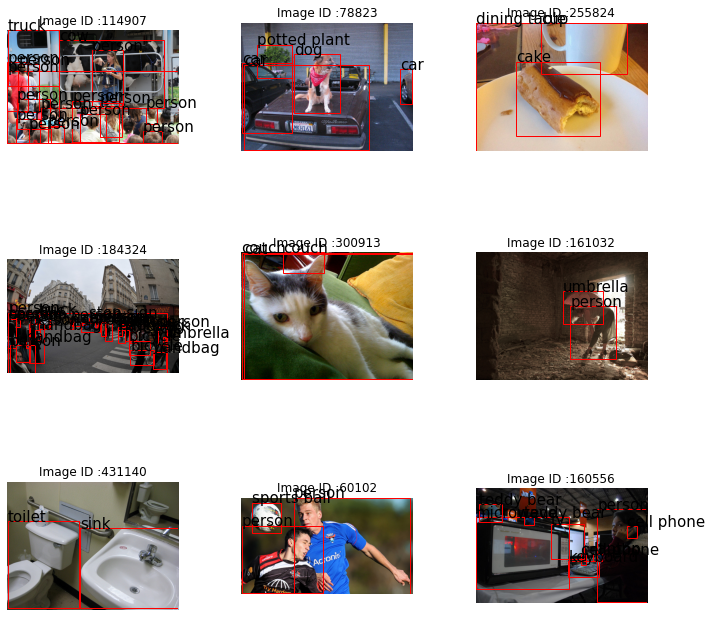

In [114]:
coco_show(testset, shape=(3,3))

# Model

In [115]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
summary(model, (2,3,224,224))

Layer (type:depth-idx)                                  Output Shape              Param #
FasterRCNN                                              --                        --
├─BackboneWithFPN: 1                                    --                        --
│    └─FeaturePyramidNetwork: 2                         --                        --
│    │    └─ModuleList: 3-1                             --                        984,064
│    │    └─ModuleList: 3-2                             --                        2,360,320
├─GeneralizedRCNNTransform: 1-1                         --                        --
├─BackboneWithFPN: 1-2                                  [2, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                     [2, 2048, 25, 25]         --
│    │    └─Conv2d: 3-3                                 [2, 64, 400, 400]         (9,408)
│    │    └─FrozenBatchNorm2d: 3-4                      [2, 64, 400, 400]         --
│    │    └─ReLU: 3-5                      

# CUDA

In [116]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Inference

In [128]:
with torch.no_grad():
    model.eval()
    
    total_gt_bboxes = torch.tensor([])
    total_pred_bboxes = torch.tensor([])
    with tqdm(test_loader, unit='iter') as iters:
        for i, (img_ids, images, targets) in enumerate(iters):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for img_id, target, output in zip(img_ids, targets, outputs):
                gt_bboxes = get_bbox(img_id, target)
                pred_bboxes = get_bbox(img_id, output, pred=True)

                total_gt_bboxes = torch.cat([total_gt_bboxes, gt_bboxes])
                total_pred_bboxes = torch.cat([total_pred_bboxes, pred_bboxes])

      #      print('r\')
        
print('Shape of total ground Truths bboxes :', total_gt_bboxes.shape)
print('Shape of total predicted bboxes :', total_pred_bboxes.shape)

100%|████████████████████████████████████████████████| 2476/2476 [08:12<00:00,  5.03iter/s]

Shape of total ground Truths bboxes : torch.Size([36759, 6])
Shape of total predicted bboxes : torch.Size([173137, 7])


# mAP

In [134]:
mAP, AP_per_classes = mean_average_precision(total_pred_bboxes,
                                             total_gt_bboxes,
                                             iou_threshold=0.5,
                                             box_format='corner',
                                             num_classes=91)
print('mAP :', mAP)
print(AP_per_classes)

100%|███████████████████████████████████████████████████| 91/91 [05:46<00:00,  3.80s/class]

mAP : tensor(0.5554)
tensor([0.0000, 0.8374, 0.6382, 0.7490, 0.7748, 0.8956, 0.8171, 0.8402, 0.5992,
        0.6461, 0.6631, 0.8783, 0.0000, 0.7649, 0.6519, 0.3958, 0.5587, 0.8820,
        0.8090, 0.8294, 0.7440, 0.7639, 0.8262, 0.8173, 0.9214, 0.9235, 0.0000,
        0.3717, 0.6461, 0.0000, 0.0000, 0.3480, 0.6356, 0.5909, 0.8326, 0.6419,
        0.6024, 0.6691, 0.6620, 0.5618, 0.6206, 0.7952, 0.6856, 0.7806, 0.5901,
        0.0000, 0.6285, 0.6102, 0.5961, 0.3944, 0.2946, 0.5952, 0.4848, 0.3057,
        0.5092, 0.4306, 0.5094, 0.4591, 0.4320, 0.7360, 0.5508, 0.5805, 0.5076,
        0.6329, 0.5302, 0.6269, 0.0000, 0.4469, 0.0000, 0.0000, 0.7887, 0.0000,
        0.7483, 0.7612, 0.7964, 0.5941, 0.7524, 0.5768, 0.7144, 0.5920, 0.3963,
        0.6981, 0.7314, 0.0000, 0.3543, 0.7836, 0.5839, 0.3579, 0.6988, 0.0472,
        0.4466])
